# Statistical Baselines

In this notebook we perform some rudemantary data analysis so we can get a grasp of our underlying 'ag-news' dataset. Further than this we will train some baseline classifiers, including two very simplistic ones:
- Constant Predictor
- Majority Class Predictor

As we will see, the two simplistic classifiers turn out to have the same accuracy. Afterwards we will use a more interesting approach by tokenising our vocabulary using the [GloVe](https://nlp.stanford.edu/projects/glove/), from Standford unviersity, and then training a RandomForestClassifier on this newly adapted dataset.


In [25]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter

import csv

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint

from tensorflow.keras.preprocessing.text import Tokenizer

## Dataset extraction

Below we open the csv file 'train.csv'. This file contains the headers 'Class Index, Title, Description'.

Importantly, here we also keep track of all the words found during the extraction of this data - this is important for creating our vocabulary later.

In [26]:

data = []
words = []

with open('data/train.csv') as f:
  reader = csv.reader(f)
  next(reader)
  for row in reader:

    # Tokenisation of words for embedding creation
    t = int(row[0])
    title = row[1].split()
    title = [t.lower() for t in title]
    description = row[2].split()
    description = [d.lower() for d in description]
    try:
      words.extend(t.lower() for t in title)
    except:
      pass

    data.append([t,title,description]) # List containing the index title and description

In [27]:
# We now create the dictionary and tokenize the words
tokenize = Tokenizer()
tokenize.fit_on_texts(words)

In [28]:
# Examples of the underlying token
print("Number of unique words in dictionary = ",len(tokenize.word_index))
first_ten_entries = {key: tokenize.word_index[key] for key in list(tokenize.word_index.keys())[:10]}
print("The first ten entries of the dictionary are = ", first_ten_entries)

Number of unique words in dictionary =  36752
The first ten entries of the dictionary are =  {'to': 1, 'in': 2, '39': 3, 'for': 4, 'on': 5, 'of': 6, 's': 7, 'ap': 8, 'the': 9, 'b': 10}


## Dataset Analysis

We
- Show the class distribution - we can see below that it is perfectly **balanced**
- Show the distribution of words
- Show the most common words in the dataset
    - We have some interesting observations here; evidently the most common words are going to be of the least importance to us as most titles will contain at least some of them. Furthermore, it appears we have some special characters i.e. #39;s. Whilst these are not helpful they will also not provide any information on class index so should not impact the performance of our model.


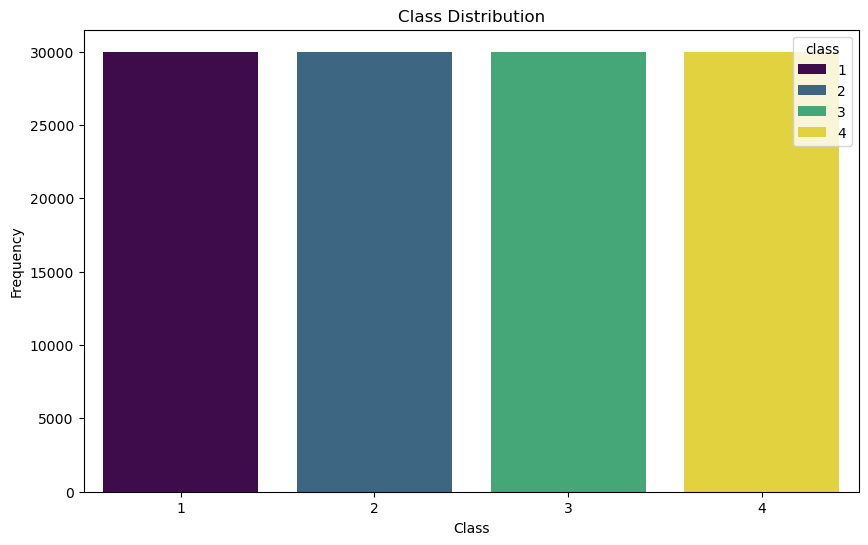

In [29]:
df = pd.DataFrame(data, columns=['class','title','description'])

# Plot class distribution
plt.figure(figsize=(10, 6))
sns.countplot(x='class',hue='class', data=df, palette='viridis')
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.show()

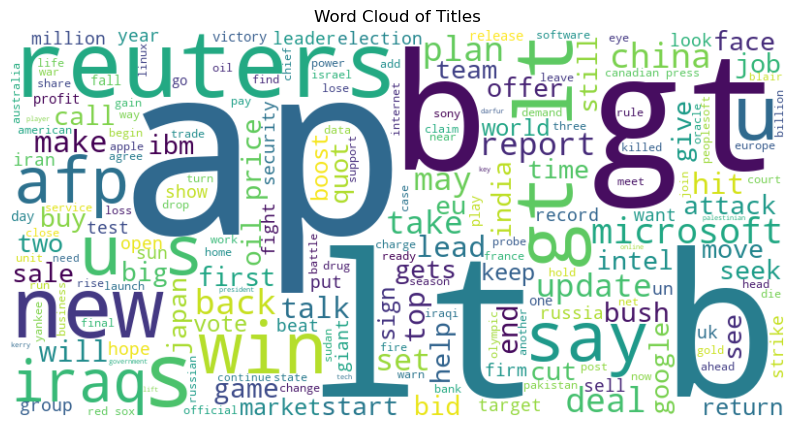

In [30]:
# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(words))

# Display the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Titles')
plt.show()

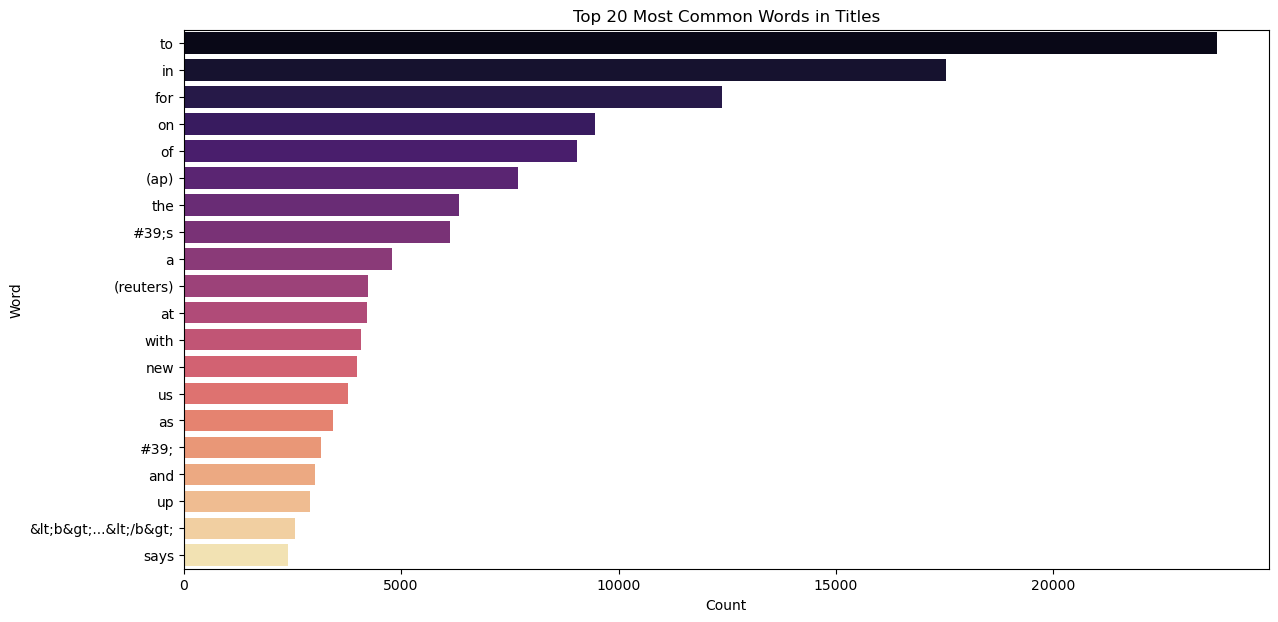

In [31]:
# Count word frequencies
word_freq = Counter(words)
common_words = word_freq.most_common(20)  # Get 20 most common words

# Prepare data for plotting
words_df = pd.DataFrame(common_words, columns=['word', 'count'])

# Plot the top words
plt.figure(figsize=(14, 7))
sns.barplot(x='count', y='word', hue='word', data=words_df, palette='magma')
plt.title('Top 20 Most Common Words in Titles')
plt.xlabel('Count')
plt.ylabel('Word')
plt.show()

## Creating our embeddings

In [3]:
# We now fetch the pre-trained gloVe word embeddings

!wget -P data http://nlp.stanford.edu/data/glove.6B.zip
!unzip data/glove*.zip -d data

--2024-05-17 14:19:20--  http://nlp.stanford.edu/data/glove.6B.zip
Auflösen des Hostnamens nlp.stanford.edu (nlp.stanford.edu)… 171.64.67.140
Verbindungsaufbau zu nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80 … verbunden.
HTTP-Anforderung gesendet, auf Antwort wird gewartet … 302 Found
Platz: https://nlp.stanford.edu/data/glove.6B.zip [folgend]
--2024-05-17 14:19:21--  https://nlp.stanford.edu/data/glove.6B.zip
Verbindungsaufbau zu nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443 … verbunden.
HTTP-Anforderung gesendet, auf Antwort wird gewartet … 301 Moved Permanently
Platz: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [folgend]
--2024-05-17 14:19:22--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Auflösen des Hostnamens downloads.cs.stanford.edu (downloads.cs.stanford.edu)… 171.64.64.22
Verbindungsaufbau zu downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443 … verbunden.
HTTP-Anforderung gesendet, auf Antwort wird gewartet … 200 

Below for each of our words that we have in our tokenizer we create an embedding of dimension 100.

In [33]:
# create the dict and tokenize the words
tokenizer = Tokenizer()
tokenizer.fit_on_texts(words)


# Creates a dictionary that maps each unique word to an idx.
print("Number of unique words in dictionary = ",len(tokenizer.word_index))
first_ten_entries = {key: tokenizer.word_index[key] for key in list(tokenizer.word_index.keys())[:10]}
print("The first ten entries of the dictionary are = ", first_ten_entries)

Number of unique words in dictionary =  36752
The first ten entries of the dictionary are =  {'to': 1, 'in': 2, '39': 3, 'for': 4, 'on': 5, 'of': 6, 's': 7, 'ap': 8, 'the': 9, 'b': 10}


In [34]:

def embedding_for_vocab(filepath, word_index,

                        embedding_dim):
    vocab_size = len(word_index) + 1

    # Adding again 1 because of reserved 0 index
    embedding_matrix_vocab = np.zeros((vocab_size,
                                       embedding_dim))

    with open(filepath, encoding="utf8") as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word]
                embedding_matrix_vocab[idx] = np.array(
                    vector, dtype=np.float32)[:embedding_dim]

    return embedding_matrix_vocab


# matrix for vocab: word_index
embedding_dim = 100
embedding_matrix_vocab = embedding_for_vocab(
    'data/glove.6B.100d.txt', tokenizer.word_index,
  embedding_dim)

print("Dense vector for the first word is => \n",
      embedding_matrix_vocab[1])

Dense vector for the first word is => 
 [-1.89700007e-01  5.00239991e-02  1.90840006e-01 -4.91839983e-02
 -8.97369981e-02  2.10060000e-01 -5.49520016e-01  9.83769968e-02
 -2.01350003e-01  3.42409998e-01 -9.26769972e-02  1.60999998e-01
 -1.32679999e-01 -2.81599998e-01  1.87370002e-01 -4.29589987e-01
  9.60389972e-01  1.39719993e-01 -1.07809997e+00  4.05180007e-01
  5.05389988e-01 -5.50639987e-01  4.84400004e-01  3.80439997e-01
 -2.90549989e-03 -3.49420011e-01 -9.96960029e-02 -7.83680022e-01
  1.03629994e+00 -2.31399998e-01 -4.71210003e-01  5.71259975e-01
 -2.14540005e-01  3.59580010e-01 -4.83190000e-01  1.08749998e+00
  2.85239995e-01  1.24470003e-01 -3.92480008e-02 -7.67320022e-02
 -7.63429999e-01 -3.24090004e-01 -5.74899971e-01 -1.08930004e+00
 -4.18110013e-01  4.51200008e-01  1.21119998e-01 -5.13670027e-01
 -1.33489996e-01 -1.13779998e+00 -2.87680000e-01  1.67740002e-01
  5.58040023e-01  1.53869998e+00  1.88590009e-02 -2.97210002e+00
 -2.42160007e-01 -9.24950004e-01  2.19919991e+00  

## Random Forest Classification

Random forest classifiers typically take a single input for making a decision. For this reason we have chosen to aggregate our embeddings. Currently, our title will have an individual word embedding for each word, but evidently to classify a title into a category based on e.g. the word "the" (its embbeding) is not at all useful, since it is too general and will very likely be encountered in every class. For this reason, we aggregate our title by averaging the word embeddings across all the words contained in the title.


In [35]:

# For a list of strings gather their respective word embeddings then average them

def get_list_embedding(list, embedding_matrix, vocab_idx):

  title_embedding = []

  for word in list:
    if word in vocab_idx:

      idx = vocab_idx[word]
      embedding = embedding_matrix[idx]
      title_embedding.append(embedding)


  return np.mean(title_embedding)


print(get_list_embedding(["the","lazy","dog"], embedding_matrix_vocab, tokenizer.word_index))

# For each title, and description we generate the embedding!
for d in data:
  d[1] = get_list_embedding(d[1], embedding_matrix_vocab, tokenizer.word_index)
  d[2] = get_list_embedding(d[2],embedding_matrix_vocab, tokenizer.word_index)


0.01505926504964009


/Users/samwallace/opt/miniconda3/envs/DL/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/samwallace/opt/miniconda3/envs/DL/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [36]:
# Data => Train, test split

data = pd.DataFrame(data, columns = ("Target","Title","Description"))

print(data.shape)
data = data.dropna()


X = data.drop("Target", axis = 1)
y = data["Target"]

# Train split

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2)

(120000, 3)


In [37]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

RandomForestClassifier()

Accuracy: 0.33438985736925514


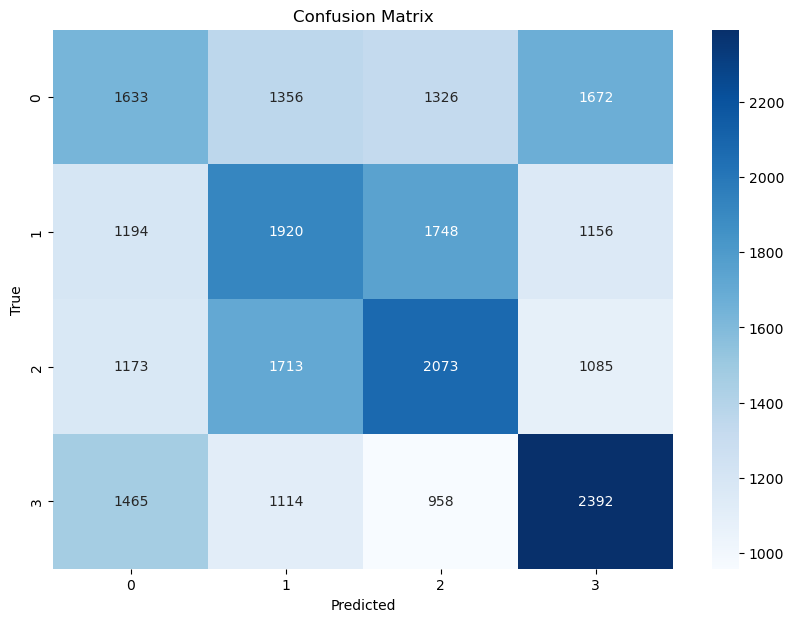

In [38]:
# We now predict on our test set, compute an accuracy score and plot the confusion matrix!

y_pred = rf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

cm = confusion_matrix(y_test, y_pred)

# Create a heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

## Conclusion

Currently, using this approach we are achieving an accuracy of about 33%. This definitley statistically significant, especially when we consider that the classes are evenly balanced, so a generic one class predictor would only attain a 25% accuracy. However there is clearly much room for improvement. We suspect that the relatively bad classification accuracy is caused by our aggregation metric of just averaging the word embeddings. Perhaps this is too simplistic and removes the nuances that the model needs to learn the dependencies.